In [1]:
# %matplotlib inline
%pylab inline
import scipy
from pyiga import bspline, assemble, vform, geometry, vis, solvers
import numpy as np
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


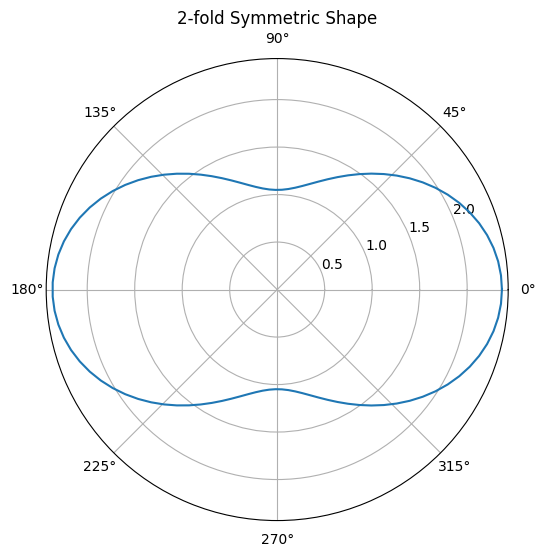

In [2]:
def cal_c(r, a, L0):
    return np.sqrt(2)*np.sqrt(np.pi*(3+3*r**2+2*r)*a*L0)/(np.pi*(3+3*r**2+2*r))
def superformula(theta, r, d, n, a, L0):
    c = cal_c(r,a,L0)
    return c*((1+r)-d*(-1)**((n+2)/2)*(r-1)*np.cos(n*theta))
d = 0.9
r = 0.4
n = 2
a = 0.4
L0 = 25
theta_values = np.linspace(0, 2 * np.pi, 100)
result = superformula(theta_values, r, d, n, a, L0)
plt.figure(figsize=(6, 6))
plt.polar(theta_values, result)
plt.title(f"{n}-fold Symmetric Shape")
plt.show()
def polar_to_cartesian(result, theta):
    x = result * np.cos(theta)
    y = result * np.sin(theta)
    return (x,y)
theta_values = np.linspace(0, 2 * np.pi, 100)
result = superformula(theta_values, r, d, n, a, L0)


In [3]:
def cal_c(r, a, L0):
    return np.sqrt(2)*np.sqrt(np.pi*(3+3*r**2+2*r)*a*L0)/(np.pi*(3+3*r**2+2*r))
def superformula(theta, r, d, n, a, L0):
    c = cal_c(r,a,L0)
    return c*((1+r)-d*(-1)**((n+2)/2)*(r-1)*np.cos(n*theta))
def polar_to_cartesian(result, theta):
    x = result * np.cos(theta)
    y = result * np.sin(theta)
    return (x,y)
def iga(kvs,geo):
    g = lambda x,y: 0  # Dirichlet BC function
    f = lambda x,y: 3 # source term

    # compute Dirichlet boundary conditions
    bcs = assemble.compute_dirichlet_bcs(kvs, geo, [('left', g), ('right', g)])

    # compute right-hand side from function f
    rhs = assemble.inner_products(kvs, f, f_physical=True, geo=geo).ravel()
    # set up and solve linear system
    A = assemble.stiffness(kvs, geo)
    LS = assemble.RestrictedLinearSystem(A, rhs, bcs)

    u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
    u_func = geometry.BSplineFunc(kvs, LS.complete(u))
    return u_func
    


In [ ]:
import matplotlib.pyplot as plt
from pyiga.geometry import *
from pyiga import approx, bspline
import os

# Define the folder name and path
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')
folder_name = os.path.join(desktop_path, 'superformula_dataset')

# Create the folder if it doesn't exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# List of subfolders to be created
subfolders = ['parameters', 'nurbs', 'iga']

# Create each subfolder
paths = {}
for subfolder in subfolders:
    path = os.path.join(folder_name, subfolder)
    os.makedirs(path, exist_ok=True)
    paths[subfolder] = path
parameters_path = paths['parameters']
nurbs_path = paths['nurbs']
iga_path = paths['iga']
ns = np.arange(4, 12, 2).tolist()
rs = [round(num, 2) for num in np.arange(0.2, 0.9, 0.1).tolist()]
n_kv = 100
kv = bspline.make_knots(1, 0.0, 1.0, n_kv)
kv_iga = kvs = 2*(kv,)

num_res = kv.numdofs
theta_values = np.linspace(0, 2 * np.pi, num_res)
w = np.ones((1,num_res))
g = geometry.line_segment([0.5,0.5], [1,1])

d = 0.8
a = 0.1
L0 = 25
for n in ns:
    for r in rs:
        result = superformula(theta_values, r, d, n, a, L0)
        coeffs = np.array(polar_to_cartesian(result, theta_values))
        coeffs = np.vstack((coeffs, w)).transpose()
        nurbs = NurbsFunc((kv,), coeffs.copy(), weights=None)
        geo = geometry.outer_product(nurbs, g)
        grid = (np.linspace(0.0, 1.0, 8),)
        vis.plot_geo(geo, gridx = 50, gridy = 5, grid = grid, res = 400)
        plt.axis('equal')
        nurbs_pic = os.path.join(nurbs_path, f'file_n{n}_r{r}.png')
        plt.savefig(nurbs_pic)
        plt.clf()  # Clear the figure
        
        file_name = os.path.join(parameters_path, f'file_n{n}_r{r}.npz')
        np.savez(file_name, coeffs=coeffs, kvs=kv, 
                 r=r, n=n, d=d,a = a, L0 = L0)
        
        u_func = iga(kv_iga, geo)
        # plot coefficients and solution
        figsize(12,6)
        
        # subplot(1,2,1)
        # pcolormesh(u_func.coeffs)
        # gca().set_aspect('equal')

        # subplot(1,2,2)
        vis.plot_field(u_func, geo, res = 500)
        gca().set_aspect('equal')
        colorbar();
        iga_pic = os.path.join(iga_path, f'file_n{n}_r{r}.png')
        plt.savefig(iga_pic)
        plt.clf()  # Clear the figur
        

        


        

In [ ]:
ns

[2, 4, 6, 8, 10]

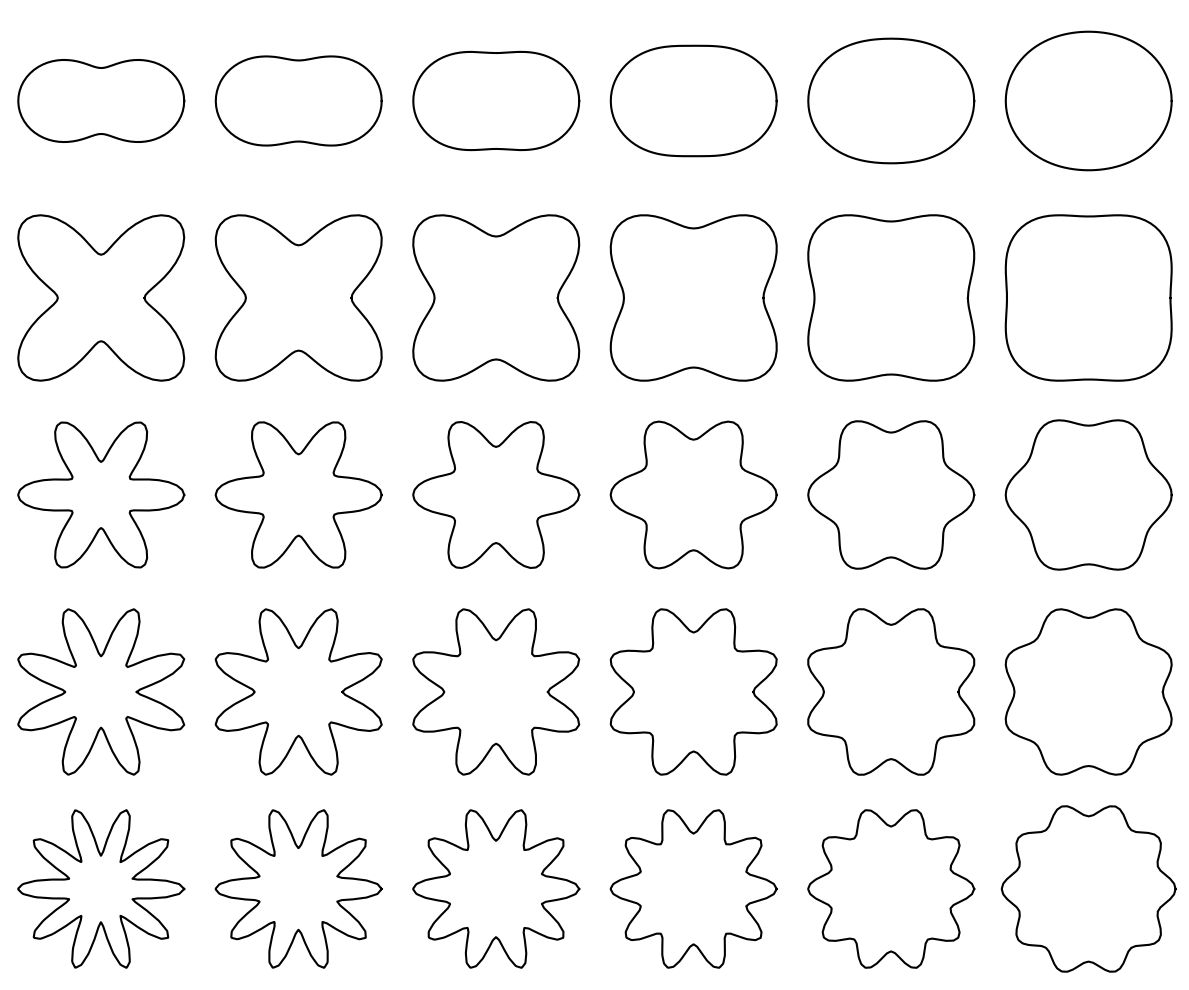

In [23]:

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(5, 6, figsize=(12, 10))  # Create a 5x6 grid of subplots
ns = np.arange(2, 12, 2).tolist()
rs = [round(num, 2) for num in np.arange(0.3, 0.9, 0.1).tolist()]
for i in range(5):
    for j in range(6):
        n = ns[i]
        r = rs[j]
        result = superformula(theta_values, r, d, n, a, L0)
        coeffs = np.array(polar_to_cartesian(result, theta_values))
        coeffs = np.vstack((coeffs, w)).transpose()
        nurbs = NurbsFunc((kv,), coeffs.copy(), weights=None)
        vals = nurbs.grid_eval(grid)
        
        ax = axes[i, j]  # Get the current axis
        plt.sca(ax)  # Set the current axis
        vis.plot_geo(nurbs,res=500, linewidth=None, color='black')
        plt.axis('equal')  # Set equal axis scaling
                # Remove ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Remove the box (spines)
        for spine in ax.spines.values():
            spine.set_visible(False)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)
(2,)
(101, 2)


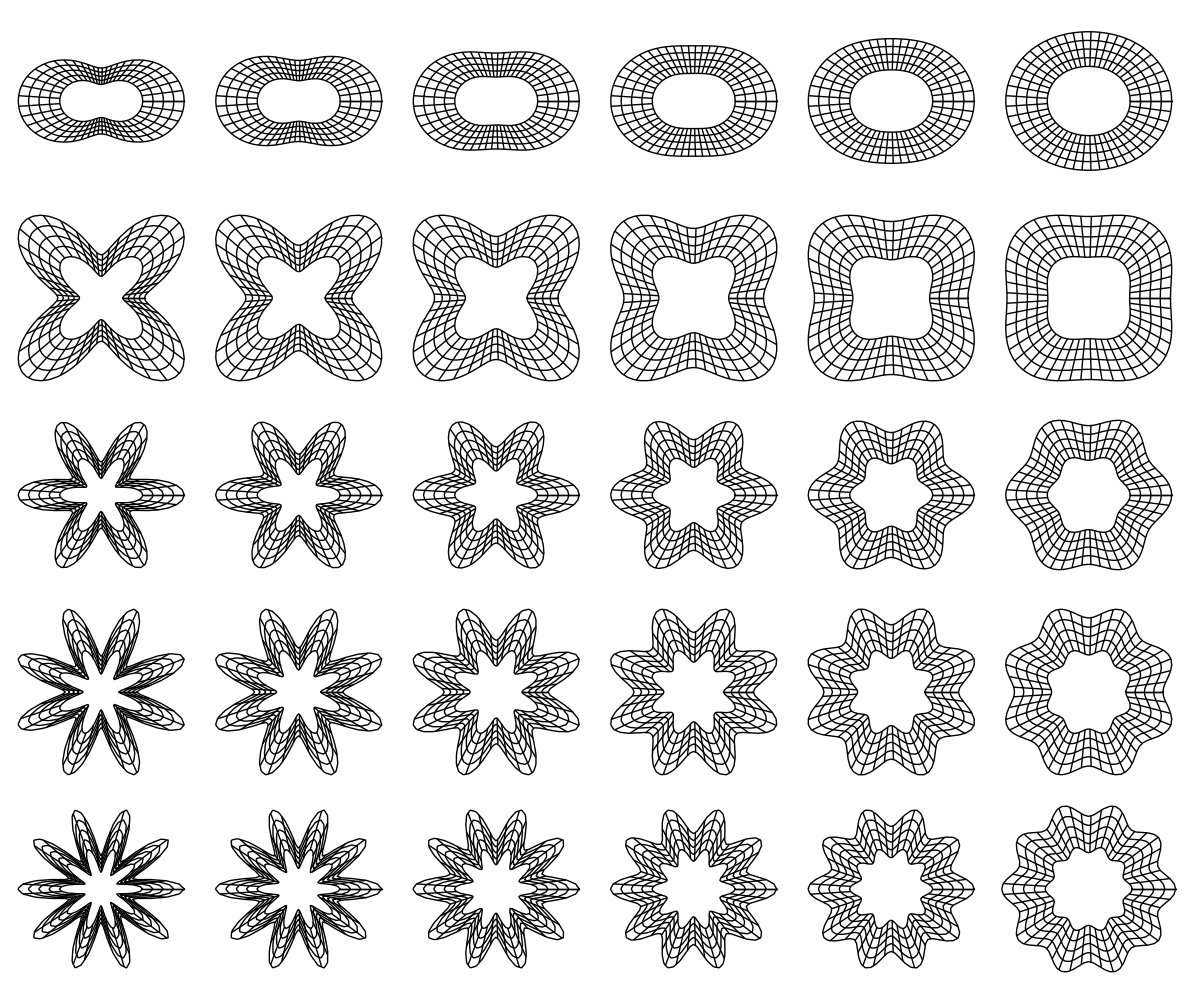

In [22]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(5, 6, figsize=(12, 10))  # Create a 5x6 grid of subplots
ns = np.arange(2, 12, 2).tolist()
rs = [round(num, 2) for num in np.arange(0.3, 0.9, 0.1).tolist()]
for i in range(5):
    for j in range(6):
        n = ns[i]
        r = rs[j]
        result = superformula(theta_values, r, d, n, a, L0)
        coeffs = np.array(polar_to_cartesian(result, theta_values))
        coeffs = np.vstack((coeffs, w)).transpose()
        nurbs = NurbsFunc((kv,), coeffs.copy(), weights=None)
        geo = geometry.outer_product(nurbs, g)
        grid = (np.linspace(0.0, 1.0, 8),)
        # vis.plot_geo(geo, gridx = 50, gridy = 5, grid = grid, res = 400)
        # plt.axis('equal')
        # axes[i, j].plot(np.random.rand(10))  # Example plot
        # axes[i, j].set_title(f"Plot {i*6 + j + 1}")
        # axes[i, j].axis("off")  # Hide axes for a cleaner look
        ax = axes[i, j]  # Get the current axis
        plt.sca(ax)  # Set the current axis
        vis.plot_geo(geo, gridx=50, gridy=5, grid=grid, res=400,linewidth=1)  # Your plot function
        plt.axis('equal')  # Set equal axis scaling
                # Remove ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Remove the box (spines)
        for spine in ax.spines.values():
            spine.set_visible(False)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


(2,)
(101, 2)
grid eval from bspline function is used
grid eval from bspline function is used
grid eval from bspline function is used
(2,)
(101, 2)
grid eval from bspline function is used
grid eval from bspline function is used
grid eval from bspline function is used
(2,)
(101, 2)
grid eval from bspline function is used
grid eval from bspline function is used
grid eval from bspline function is used
(2,)
(101, 2)
grid eval from bspline function is used
grid eval from bspline function is used
grid eval from bspline function is used
(2,)
(101, 2)
grid eval from bspline function is used
grid eval from bspline function is used
grid eval from bspline function is used
(2,)
(101, 2)
grid eval from bspline function is used
grid eval from bspline function is used
grid eval from bspline function is used
(2,)
(101, 2)
grid eval from bspline function is used
grid eval from bspline function is used
grid eval from bspline function is used
(2,)
(101, 2)
grid eval from bspline function is used
grid eva

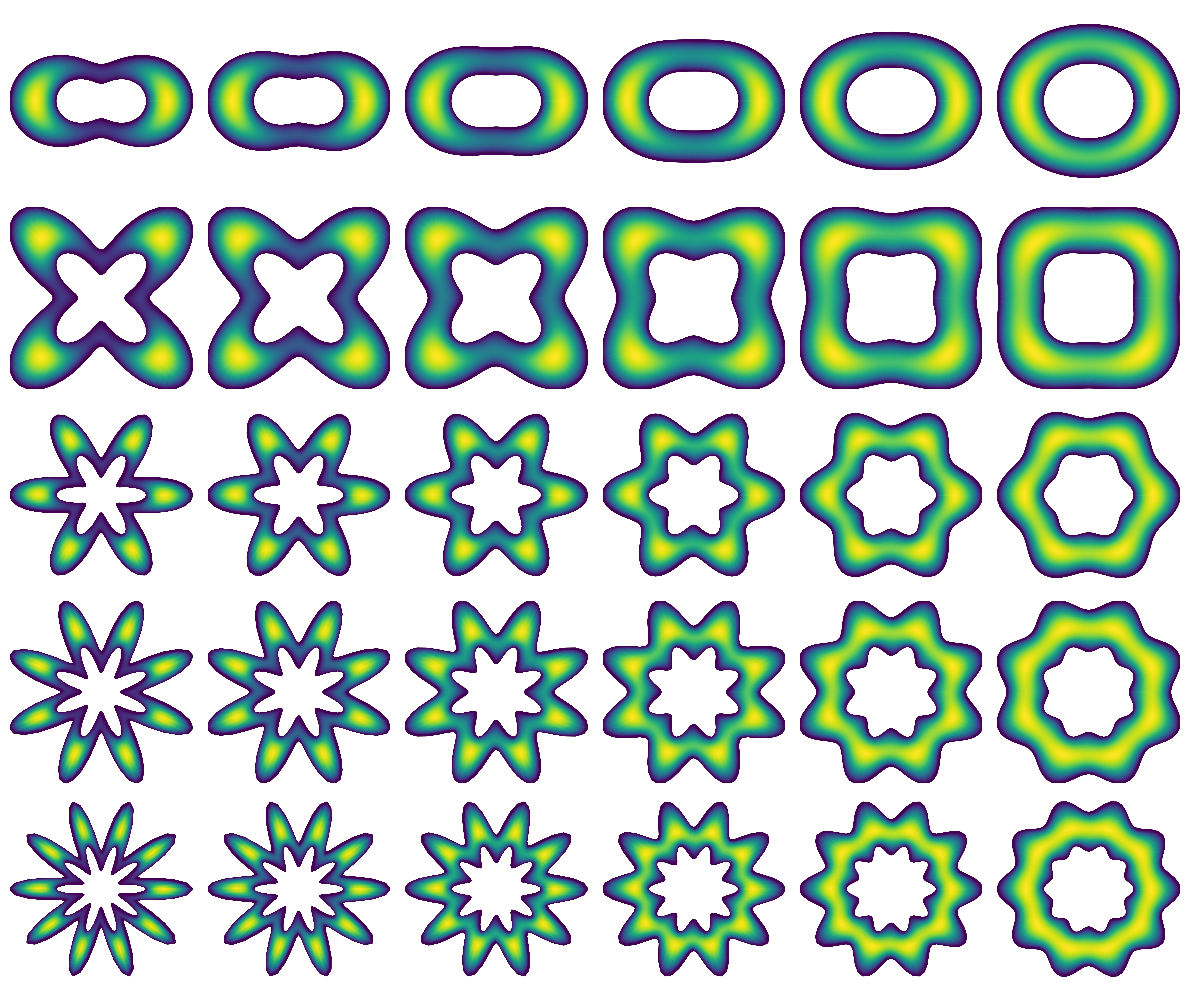

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(5, 6, figsize=(12, 10))  # Create a 5x6 grid of subplots
ns = np.arange(2, 12, 2).tolist()
rs = [round(num, 2) for num in np.arange(0.3, 0.9, 0.1).tolist()]
for i in range(5):
    for j in range(6):
        n = ns[i]
        r = rs[j]
        result = superformula(theta_values, r, d, n, a, L0)
        coeffs = np.array(polar_to_cartesian(result, theta_values))
        coeffs = np.vstack((coeffs, w)).transpose()
        nurbs = NurbsFunc((kv,), coeffs.copy(), weights=None)
        geo = geometry.outer_product(nurbs, g)
        grid = (np.linspace(0.0, 1.0, 8),)
        u_func = iga(kv_iga, geo)

        ax = axes[i, j]  # Get the current axis
        plt.sca(ax)  # Set the current axis
        vis.plot_field(u_func, geo, res = 1000)
        # gca().set_aspect('equal')
        # colorbar();        
        plt.axis('equal')  # Set equal axis scaling
                # Remove ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Remove the box (spines)
        for spine in ax.spines.values():
            spine.set_visible(False)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


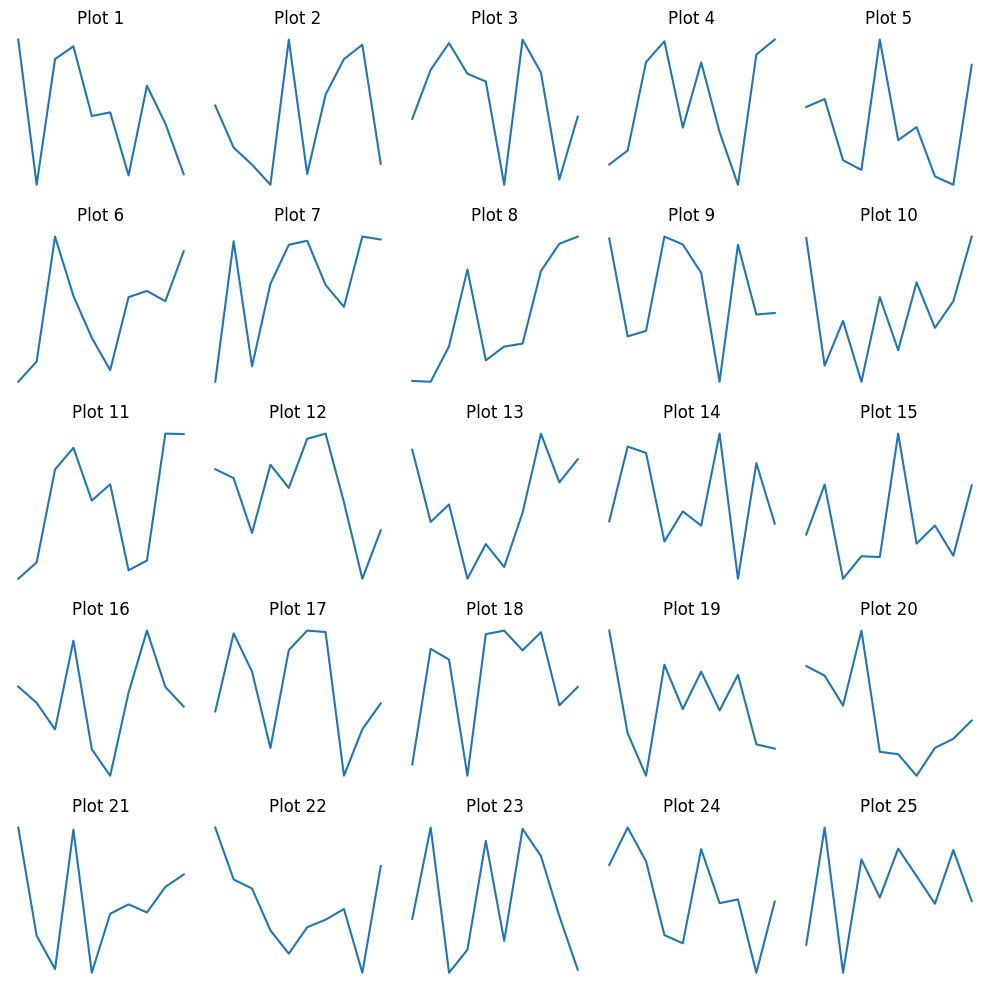

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # Create a 5x5 grid of subplots

for i in range(5):
    for j in range(5):
        axes[i, j].plot(np.random.rand(10))  # Example plot
        axes[i, j].set_title(f"Plot {i*5 + j + 1}")
        axes[i, j].axis("off")  # Hide axes for a cleaner look

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [5]:
# To load the file
for n in ns:
    for r in rs:
        file_name = os.path.join(folder_name, f'file_n{n}_r{r}.npz')
        data = np.load(file_name)
        # Access data
        loaded_matrix = data['matrix']
        loaded_array = data['array']
        loaded_int_param = data['int_param'][0]  # extract integer from array
        loaded_float_param = data['float_param'][0]  # extract float from array

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\mechadmin\\Desktop\\superformula_dataset\\file_n2_r0.2.npz'